In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Try to import sentence-transformers
try:
    from sentence_transformers import SentenceTransformer
    print("sentence-transformers library available")
    SBERT_AVAILABLE = True
except ImportError:
    print("sentence-transformers not installed")
    print("Install with: pip install sentence-transformers")
    SBERT_AVAILABLE = False

Libraries imported successfully!
sentence-transformers library available


In [2]:
# Load the data
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (104, 5)

First few rows:


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources prof...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,NaN


## Sentence-BERT Ranking System

SBERT advantages for HR matching:
- **Semantic Understanding**: Deep contextual understanding from BERT
- **Pre-trained Knowledge**: Trained on billions of words
- **Sentence-level**: Captures full context, not just word averaging
- **State-of-the-art**: Best performance on semantic similarity benchmarks

In [3]:
class SBERTRankingSystem:
    """
    A ranking system using Sentence-BERT embeddings for semantic matching.
    """
    
    def __init__(self, keywords, model_name='all-MiniLM-L6-v2', use_connections=True):
        """
        Initialize the SBERT ranking system.
        
        Parameters:
        -----------
        keywords : str or list
            Target role keywords to match against
        model_name : str
            Pre-trained SBERT model name
            Options: 
            - 'all-MiniLM-L6-v2' (fast, 384 dim)
            - 'all-mpnet-base-v2' (best quality, 768 dim)
            - 'paraphrase-MiniLM-L6-v2' (paraphrase detection)
        use_connections : bool
            Whether to factor in number of connections
        """
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.model_name = model_name
        self.starred_candidates = []
        self.ranking_history = []
        
        # Load SBERT model
        if SBERT_AVAILABLE:
            print(f"Loading SBERT model: {model_name}...")
            self.model = SentenceTransformer(model_name)
            print(f"Model loaded. Embedding dimension: {self.model.get_sentence_embedding_dimension()}")
        else:
            print("SBERT not available. Please install: pip install sentence-transformers")
            self.model = None
        
    def preprocess_text(self, text):
        """
        Light preprocessing for SBERT.
        SBERT models are trained on natural text, so we keep punctuation.
        """
        if pd.isna(text):
            return ""
        return str(text).strip()
    
    def normalize_connections(self, connections_series):
        """Normalize connection counts to 0-1 scale."""
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def get_embeddings(self, texts):
        """
        Get SBERT embeddings for a list of texts.
        """
        if not SBERT_AVAILABLE or self.model is None:
            raise RuntimeError("SBERT not available")
        
        # SBERT handles everything internally - no need for manual tokenization
        embeddings = self.model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
        return embeddings
    
    def calculate_initial_fit(self, df):
        """Calculate initial fitness scores using SBERT embeddings."""
        if not SBERT_AVAILABLE or self.model is None:
            raise RuntimeError("SBERT not available")
        
        # Preprocess texts
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        
        # Get embeddings
        all_texts = [self.keywords] + df['processed_title'].tolist()
        all_embeddings = self.get_embeddings(all_texts)
        
        # Split keyword and job embeddings
        keyword_vector = all_embeddings[0:1]
        job_vectors = all_embeddings[1:]
        
        # Calculate cosine similarity
        similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        # Factor in connections if enabled
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def calculate_fit_with_feedback(self, df, starred_indices):
        """Recalculate fitness incorporating starred candidates."""
        if not SBERT_AVAILABLE or self.model is None:
            raise RuntimeError("SBERT not available")
        
        # Preprocess texts
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        
        # Get embeddings
        all_texts = [self.keywords] + df['processed_title'].tolist()
        all_embeddings = self.get_embeddings(all_texts)
        
        keyword_vector = all_embeddings[0:1]
        job_vectors = all_embeddings[1:]
        
        # Base similarity to keywords
        keyword_similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        if len(starred_indices) > 0:
            # Calculate similarity to starred candidates
            starred_vectors = job_vectors[starred_indices]
            starred_similarities = cosine_similarity(job_vectors, starred_vectors)
            max_starred_sim = starred_similarities.max(axis=1)
            
            # Combine scores
            weight_starred = min(0.6, 0.3 + (len(starred_indices) * 0.05))
            weight_keyword = 1 - weight_starred
            
            combined_scores = (weight_keyword * keyword_similarities + 
                             weight_starred * max_starred_sim)
        else:
            combined_scores = keyword_similarities
        
        # Factor in connections
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.85 * combined_scores + 0.15 * connection_scores
        else:
            final_scores = combined_scores
        
        return final_scores
    
    def rank_candidates(self, df, starred_indices=None):
        """Rank candidates and return sorted dataframe."""
        df_copy = df.copy()
        
        if starred_indices is None or len(starred_indices) == 0:
            fit_scores = self.calculate_initial_fit(df_copy)
        else:
            fit_scores = self.calculate_fit_with_feedback(df_copy, starred_indices)
        
        df_copy['fit_sbert'] = fit_scores
        df_copy = df_copy.sort_values('fit_sbert', ascending=False).reset_index(drop=True)
        df_copy['rank'] = range(1, len(df_copy) + 1)
        
        self.ranking_history.append(df_copy[['id', 'rank', 'fit_sbert']].copy())
        
        return df_copy
    
    def star_candidate(self, df, candidate_rank):
        """Star a candidate and re-rank."""
        candidate_idx = df.index[df['rank'] == candidate_rank].tolist()[0]
        
        if candidate_idx not in self.starred_candidates:
            self.starred_candidates.append(candidate_idx)
            print(f"✭ Starred: {df.loc[candidate_idx, 'job_title']}")
        
        return self.rank_candidates(df, self.starred_candidates)
    
    def find_similar_sentences(self, query, candidates, top_k=5):
        """
        Find most similar candidates to a query.
        Useful for exploring semantic similarity.
        """
        if not SBERT_AVAILABLE or self.model is None:
            raise RuntimeError("SBERT not available")
        
        # Get embeddings
        query_embedding = self.model.encode([query], convert_to_numpy=True)
        candidate_embeddings = self.model.encode(candidates, convert_to_numpy=True)
        
        # Calculate similarities
        similarities = cosine_similarity(query_embedding, candidate_embeddings).flatten()
        
        # Get top-k
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'text': candidates[idx],
                'similarity': similarities[idx]
            })
        
        return results

print("SBERTRankingSystem class defined successfully!")

SBERTRankingSystem class defined successfully!


In [4]:
# Initialize SBERT ranking system
if SBERT_AVAILABLE:
    keywords = "aspiring human resources seeking human resources"
    
    # Using 'all-MiniLM-L6-v2' - fast and efficient (384 dimensions)
    # Alternative: 'all-mpnet-base-v2' - better quality but slower (768 dimensions)
    sbert_system = SBERTRankingSystem(
        keywords, 
        model_name='all-MiniLM-L6-v2',
        use_connections=True
    )
    
    print(f"SBERT system initialized with keywords: '{keywords}'")
else:
    print("SBERT not available. Please install: pip install sentence-transformers")

Loading SBERT model: all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded. Embedding dimension: 384
SBERT system initialized with keywords: 'aspiring human resources seeking human resources'


In [5]:
# Rank candidates using SBERT
if SBERT_AVAILABLE:
    ranked_sbert = sbert_system.rank_candidates(df)
    
    print("SBERT Ranking Complete!")
    print(f"\nTop 15 Candidates (SBERT):")
    print("="*100)
    display(ranked_sbert[['rank', 'job_title', 'location', 'connection', 'fit_sbert']].head(15))
else:
    print("Skipping SBERT ranking - library not available")

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

SBERT Ranking Complete!

Top 15 Candidates (SBERT):


,rank,job_title,location,connection,fit_sbert
0,1,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.822483
1,2,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.822483
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.789058
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.789058
4,5,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.789058
5,6,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.789058
6,7,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.779034
7,8,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.779034
8,9,"Human Resources, Staffing and Recruiting Professional","Jackson, Mississippi Area",500+,0.759894
9,10,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,0.739195


## Demonstrate SBERT's Semantic Understanding

Let's explore how SBERT captures semantic similarity.

In [6]:
# Demonstrate semantic similarity
if SBERT_AVAILABLE:
    print("Semantic Similarity Examples:")
    print("="*100)
    
    queries = [
        "human resources manager",
        "recruitment specialist",
        "talent acquisition",
        "employee relations"
    ]
    
    for query in queries:
        print(f"\nQuery: '{query}'")
        print("-" * 100)
        similar = sbert_system.find_similar_sentences(
            query, 
            df['job_title'].tolist(), 
            top_k=5
        )
        for i, result in enumerate(similar, 1):
            print(f"  {i}. {result['text']:<60} (similarity: {result['similarity']:.4f})")
else:
    print("Skipping semantic similarity demo - SBERT not available")

Semantic Similarity Examples:

Query: 'human resources manager'
----------------------------------------------------------------------------------------------------
  1. Human Resources Management Major                             (similarity: 0.8829)
  2. Human Resources Professional                                 (similarity: 0.8360)
  3. Aspiring Human Resources Specialist                          (similarity: 0.7953)
  4. Aspiring Human Resources Specialist                          (similarity: 0.7953)
  5. Aspiring Human Resources Specialist                          (similarity: 0.7953)

Query: 'recruitment specialist'
----------------------------------------------------------------------------------------------------
  1. Retired Army National Guard Recruiter, office manager,  seeking a position in Human Resources. (similarity: 0.6668)
  2. Human Resources, Staffing and Recruiting Professional        (similarity: 0.6471)
  3. Aspiring Human Resources Specialist                  

## Compare with TF-IDF Baseline

In [7]:
# Create TF-IDF baseline for comparison
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFRankingSystem:
    """Baseline TF-IDF system for comparison."""
    
    def __init__(self, keywords, use_connections=True):
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.vectorizer = TfidfVectorizer(
            stop_words='english',
            ngram_range=(1, 3),
            min_df=1,
            lowercase=True
        )
    
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def normalize_connections(self, connections_series):
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def calculate_initial_fit(self, df):
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        all_texts = [self.keywords] + df['processed_title'].tolist()
        tfidf_matrix = self.vectorizer.fit_transform(all_texts)
        
        keyword_vector = tfidf_matrix[0:1]
        candidate_vectors = tfidf_matrix[1:]
        
        similarities = cosine_similarity(keyword_vector, candidate_vectors).flatten()
        
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def rank_candidates(self, df):
        df_copy = df.copy()
        fit_scores = self.calculate_initial_fit(df_copy)
        df_copy['fit_tfidf'] = fit_scores
        df_copy = df_copy.sort_values('fit_tfidf', ascending=False).reset_index(drop=True)
        return df_copy

# Create TF-IDF baseline
tfidf_system = TFIDFRankingSystem(keywords, use_connections=True)
ranked_tfidf = tfidf_system.rank_candidates(df)

print("TF-IDF baseline created for comparison")

TF-IDF baseline created for comparison


In [8]:
# Merge results for comparison
if SBERT_AVAILABLE:
    comparison_df = ranked_sbert[['id', 'job_title', 'location', 'connection', 'rank', 'fit_sbert']].copy()
    comparison_df = comparison_df.rename(columns={'rank': 'rank_sbert'})
    
    tfidf_ranks = ranked_tfidf[['id', 'fit_tfidf']].copy()
    tfidf_ranks['rank_tfidf'] = range(1, len(tfidf_ranks) + 1)
    
    comparison_df = comparison_df.merge(tfidf_ranks, on='id', how='left')
    comparison_df['rank_difference'] = comparison_df['rank_tfidf'] - comparison_df['rank_sbert']
    
    print("Top 20 Candidates - SBERT vs TF-IDF Comparison:")
    print("="*120)
    display(comparison_df[['rank_sbert', 'rank_tfidf', 'rank_difference', 'job_title', 
                   'fit_sbert', 'fit_tfidf']].head(20))
else:
    print("Skipping comparison - SBERT not available")

Top 20 Candidates - SBERT vs TF-IDF Comparison:


,rank_sbert,rank_tfidf,rank_difference,job_title,fit_sbert,fit_tfidf
0,1,1,0,Seeking Human Resources Opportunities,0.822483,0.461002
1,2,2,0,Seeking Human Resources Opportunities,0.822483,0.461002
2,3,3,0,Seeking Human Resources HRIS and Generalist Positions,0.789058,0.416951
3,4,4,0,Seeking Human Resources HRIS and Generalist Positions,0.789058,0.416951
4,5,5,0,Seeking Human Resources HRIS and Generalist Positions,0.789058,0.416951
5,6,6,0,Seeking Human Resources HRIS and Generalist Positions,0.789058,0.416951
6,7,7,0,Aspiring Human Resources Management student seeking an internship,0.779034,0.352899
7,8,8,0,Aspiring Human Resources Management student seeking an internship,0.779034,0.352899
8,9,27,18,"Human Resources, Staffing and Recruiting Professional",0.759894,0.264212
9,10,12,2,Aspiring Human Resources Professional,0.739195,0.305680


## Visualization: SBERT vs TF-IDF

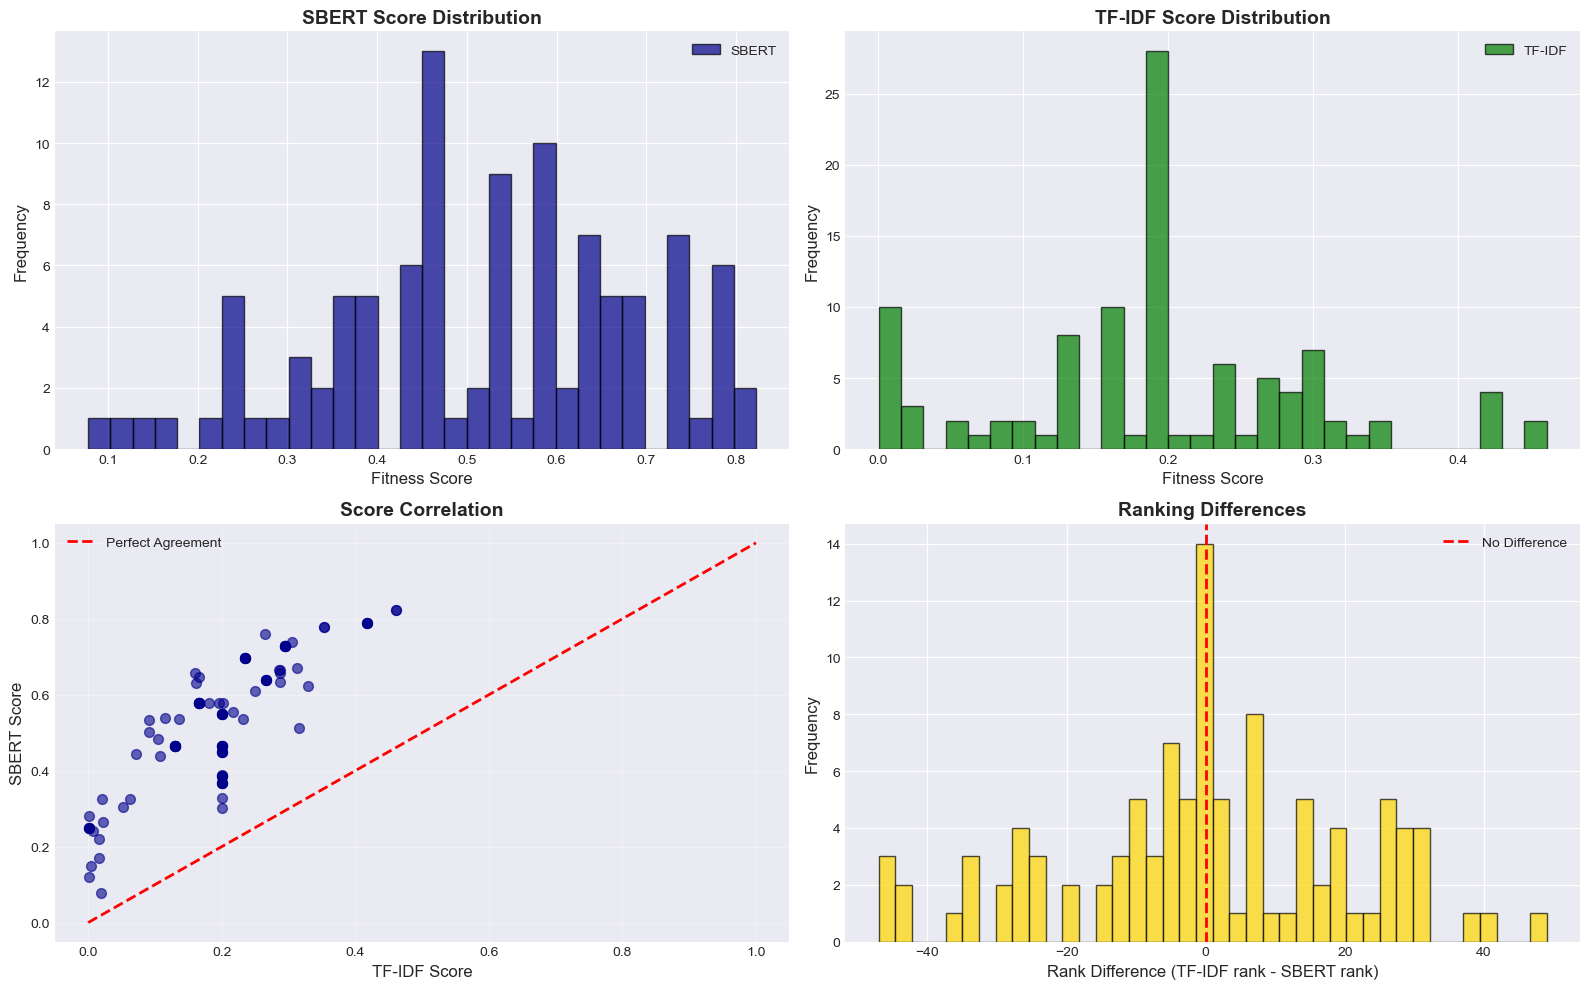


Correlation between SBERT and TF-IDF scores: 0.8410


In [9]:
# Score distribution comparison
if SBERT_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Histograms
    axes[0, 0].hist(comparison_df['fit_sbert'], bins=30, alpha=0.7, label='SBERT', color='darkblue', edgecolor='black')
    axes[0, 0].set_xlabel('Fitness Score', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('SBERT Score Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    
    axes[0, 1].hist(comparison_df['fit_tfidf'], bins=30, alpha=0.7, label='TF-IDF', color='green', edgecolor='black')
    axes[0, 1].set_xlabel('Fitness Score', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('TF-IDF Score Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    
    # Scatter plot: SBERT vs TF-IDF scores
    axes[1, 0].scatter(comparison_df['fit_tfidf'], comparison_df['fit_sbert'], alpha=0.6, s=50, color='darkblue')
    axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
    axes[1, 0].set_xlabel('TF-IDF Score', fontsize=12)
    axes[1, 0].set_ylabel('SBERT Score', fontsize=12)
    axes[1, 0].set_title('Score Correlation', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Rank difference distribution
    axes[1, 1].hist(comparison_df['rank_difference'], bins=40, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
    axes[1, 1].set_xlabel('Rank Difference (TF-IDF rank - SBERT rank)', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('Ranking Differences', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    correlation = comparison_df['fit_sbert'].corr(comparison_df['fit_tfidf'])
    print(f"\nCorrelation between SBERT and TF-IDF scores: {correlation:.4f}")
else:
    print("Skipping visualization - SBERT not available")

In [10]:
# Statistical comparison
if SBERT_AVAILABLE:
    print("Statistical Comparison:")
    print("="*80)
    print(f"\nSBERT Scores:")
    print(f"  Mean: {comparison_df['fit_sbert'].mean():.4f}")
    print(f"  Std:  {comparison_df['fit_sbert'].std():.4f}")
    print(f"  Min:  {comparison_df['fit_sbert'].min():.4f}")
    print(f"  Max:  {comparison_df['fit_sbert'].max():.4f}")
    
    print(f"\nTF-IDF Scores:")
    print(f"  Mean: {comparison_df['fit_tfidf'].mean():.4f}")
    print(f"  Std:  {comparison_df['fit_tfidf'].std():.4f}")
    print(f"  Min:  {comparison_df['fit_tfidf'].min():.4f}")
    print(f"  Max:  {comparison_df['fit_tfidf'].max():.4f}")
    
    print(f"\nRank Differences:")
    print(f"  Mean Absolute Difference: {comparison_df['rank_difference'].abs().mean():.2f}")
    print(f"  Max Rank Change: {comparison_df['rank_difference'].abs().max():.0f}")
    print(f"  Candidates with >10 rank difference: {(comparison_df['rank_difference'].abs() > 10).sum()}")
else:
    print("Skipping statistics - SBERT not available")

Statistical Comparison:

SBERT Scores:
  Mean: 0.5197
  Std:  0.1726
  Min:  0.0778
  Max:  0.8225

TF-IDF Scores:
  Mean: 0.1938
  Std:  0.1066
  Min:  0.0008
  Max:  0.4610

Rank Differences:
  Mean Absolute Difference: 15.71
  Max Rank Change: 49
  Candidates with >10 rank difference: 57


In [11]:
# Show candidates that differ the most in ranking
if SBERT_AVAILABLE:
    print("\nCandidates Ranked Much Higher by SBERT (vs TF-IDF):")
    print("="*120)
    top_sbert = comparison_df.nsmallest(10, 'rank_difference')
    print(top_sbert[['rank_sbert', 'rank_tfidf', 'rank_difference', 'job_title', 
                     'fit_sbert', 'fit_tfidf']].to_string(index=False))
    
    print("\n\nCandidates Ranked Much Higher by TF-IDF (vs SBERT):")
    print("="*120)
    top_tfidf = comparison_df.nlargest(10, 'rank_difference')
    print(top_tfidf[['rank_sbert', 'rank_tfidf', 'rank_difference', 'job_title', 
                     'fit_sbert', 'fit_tfidf']].to_string(index=False))
else:
    print("Skipping ranking difference analysis - SBERT not available")


Candidates Ranked Much Higher by SBERT (vs TF-IDF):
 rank_sbert  rank_tfidf  rank_difference                                                                                            job_title  fit_sbert  fit_tfidf
         88          41              -47                                                                       Always set them up for Success   0.327978   0.200000
         56          10              -46 Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!!  (408) 709-2621   0.511281   0.315258
         92          47              -45                                   RRP Brand Portfolio Executive at JTI (Japan Tobacco International)   0.301388   0.200000
         83          39              -44                                            Native English Teacher at EPIK (English Program in Korea)   0.367661   0.200000
         80          37              -43                                                      Advisory Board Member at Celal Ba

## Key Insights

### SBERT Strengths:
1. **Transformer Architecture**: Uses BERT's attention mechanisms for deep understanding
2. **Pre-trained on Massive Data**: Billions of sentence pairs for semantic similarity
3. **Sentence-level Embeddings**: Optimized for complete sentences, not just word averaging
4. **State-of-the-art Performance**: Best results on semantic textual similarity benchmarks
5. **Context Awareness**: Understands nuanced meanings and relationships

### SBERT Limitations:
1. **Computational Cost**: Slower than traditional methods (requires neural network inference)
2. **Model Size**: Requires downloading pre-trained models (100+ MB)
3. **Overkill for Simple Tasks**: May be unnecessary for exact keyword matching

### Comparison with TF-IDF:
- **Semantic Depth**: SBERT captures deep semantic relationships
- **Quality**: Generally produces better semantic similarity scores
- **Speed**: TF-IDF is much faster; SBERT requires GPU for large-scale use
- **Use Case**: SBERT ideal for semantic search; TF-IDF for keyword matching

### Model Options:
- **all-MiniLM-L6-v2**: Fast, 384 dimensions, good for most tasks
- **all-mpnet-base-v2**: Best quality, 768 dimensions, slower
- **multi-qa-MiniLM-L6-cos-v1**: Optimized for question-answering/search

In [12]:
# Save comparison results
if SBERT_AVAILABLE:
    comparison_df.to_csv('sbert_vs_tfidf_comparison.csv', index=False)
    print("Comparison results saved to 'sbert_vs_tfidf_comparison.csv'")
else:
    print("Skipping save - SBERT not available")

Comparison results saved to 'sbert_vs_tfidf_comparison.csv'


## Installation Instructions

To use SBERT in your environment:

```bash
pip install sentence-transformers
```

This will install:
- sentence-transformers
- transformers (Hugging Face)
- torch (PyTorch)
- And other dependencies

For GPU acceleration (optional but recommended for large datasets):
```bash
pip install sentence-transformers[gpu]
```